In [1]:
from data_preprocessing.DataLoader import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import calendar

In [2]:
d = DataLoader.load_data_from_path("data/data_new")

In [3]:
products = d.products

In [4]:
# Splitting category_path into smaller categories, so it can be easier to group them and analyze each category separately

categories = products.category_path.str.split(';', expand=True)
products = pd.concat([products, categories], axis=1)
products = products.drop(columns=['category_path'])
products = products.rename(columns= {0: "primary_category", 1 :"secondary_category", 2 : "tertiary_category", 3 : "quaternary_category"})
products['price'] = products['price'].abs()
print(products.quaternary_category)

0      None
1      None
2      None
3      None
4      None
       ... 
314    None
315    None
316    None
317    None
318    None
Name: quaternary_category, Length: 319, dtype: object


In [5]:
products.dtypes

product_id               int64
product_name            object
price                  float64
primary_category        object
secondary_category      object
tertiary_category       object
quaternary_category     object
dtype: object

In [6]:
products.describe()

,product_id,price
count,319.000000,319.000000
mean,1160.000000,247.787962
std,92.231593,813.788548
min,1001.000000,1.000000
25%,1080.500000,24.990000
50%,1160.000000,41.000000
75%,1239.500000,92.995000
max,1319.000000,7639.000000


In [7]:
deliveries = d.deliveries

In [8]:
deliveries

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2021-04-01 15:52:47,2021-04-02 14:06:34.432964,620
1,20002,2021-04-01 02:26:23,2021-04-02 10:45:27.707128,360
2,20003,2021-01-03 05:11:17,2021-01-04 15:43:07.635371,620
3,20004,2021-02-17 12:59:54,2021-02-18 11:52:42.608746,620
4,20005,2021-02-13 09:17:52,2021-02-15 08:59:28.973167,620
...,...,...,...,...
7488,27489,2021-03-07 08:53:25,2021-03-09 08:57:42.852988,620
7489,27490,2021-02-02 03:47:59,2021-02-02 16:10:25.579518,516
7490,27491,2021-03-04 07:34:59,2021-03-05 11:45:45.828316,360
7491,27492,2021-01-12 05:34:58,2021-01-13 08:07:37.900596,516


In [9]:
deliveries.dtypes

purchase_id                    int64
purchase_timestamp    datetime64[ns]
delivery_timestamp    datetime64[ns]
delivery_company               int64
dtype: object

In [10]:
deliveries

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2021-04-01 15:52:47,2021-04-02 14:06:34.432964,620
1,20002,2021-04-01 02:26:23,2021-04-02 10:45:27.707128,360
2,20003,2021-01-03 05:11:17,2021-01-04 15:43:07.635371,620
3,20004,2021-02-17 12:59:54,2021-02-18 11:52:42.608746,620
4,20005,2021-02-13 09:17:52,2021-02-15 08:59:28.973167,620
...,...,...,...,...
7488,27489,2021-03-07 08:53:25,2021-03-09 08:57:42.852988,620
7489,27490,2021-02-02 03:47:59,2021-02-02 16:10:25.579518,516
7490,27491,2021-03-04 07:34:59,2021-03-05 11:45:45.828316,360
7491,27492,2021-01-12 05:34:58,2021-01-13 08:07:37.900596,516


In [11]:
deliveries.loc[deliveries["delivery_company"].isnull(),["delivery_company"]] = "Empty"
# deliveries["delivery_company"].isnull()="Empty"

In [12]:
print(deliveries.to_string())

    27250 2021-01-23 14:24:31 2021-01-25 08:21:05.997971              620
7250        27251 2021-04-02 12:33:22 2021-04-03 08:24:25.252717              516
7251        27252 2021-03-18 03:04:29 2021-03-18 18:03:11.429127              516
7252        27253 2021-04-20 03:46:58 2021-04-21 08:06:20.485184              360
7253        27254 2021-03-06 21:30:27 2021-03-08 14:17:21.247126              360
7254        27255 2021-04-08 09:24:14 2021-04-09 08:15:00.374475              516
7255        27256 2021-01-23 16:19:03 2021-01-25 16:14:11.619088              360
7256        27257 2021-01-24 22:10:09 2021-01-25 13:26:23.297277              620
7257        27258 2021-03-19 07:14:09 2021-03-20 08:06:46.978188              360
7258        27259 2021-03-26 01:30:34 2021-03-26 08:27:04.056788              620
7259        27260 2021-04-24 22:37:25 2021-04-26 17:11:11.910804              360
7260        27261 2021-04-07 23:34:47 2021-04-08 12:11:03.655304              516
7261        27262 2021-0

In [13]:
#count difference between ordering and delivering
deltas =  deliveries.delivery_timestamp - deliveries.purchase_timestamp 

In [14]:
#get rid of None values
deltas_clean = deltas.dropna()

In [15]:
deltas_clean

0      0 days 22:13:47.432964
1      1 days 08:19:04.707128
2      1 days 10:31:50.635371
3      0 days 22:52:48.608746
4      1 days 23:41:36.973167
                ...          
7488   2 days 00:04:17.852988
7489   0 days 12:22:26.579518
7490   1 days 04:10:46.828316
7491   1 days 02:32:39.900596
7492   1 days 17:09:50.431587
Length: 7493, dtype: timedelta64[ns]

In [16]:
#take absolute values from cleand data deltas
deltas_clean_abs = deltas_clean.abs()

<AxesSubplot:ylabel='Frequency'>

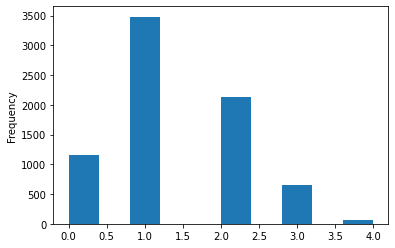

In [17]:
#delivery time without absolute values
deltas_clean.astype('timedelta64[D]').plot.hist(bins = 10)

<AxesSubplot:ylabel='Frequency'>

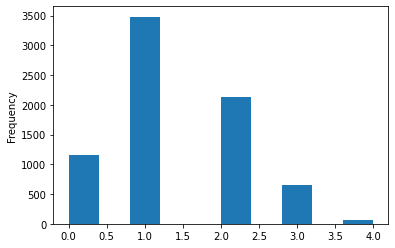

In [18]:
#delivery time without negative values
deltas_clean[deltas_clean>= pd.Timedelta(0)].astype('timedelta64[D]').plot.hist(bins = 10)

<AxesSubplot:ylabel='Frequency'>

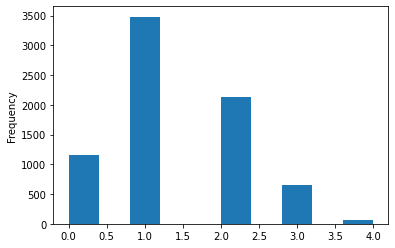

In [19]:
#delivery time with absolute values
deltas_clean_abs.astype('timedelta64[D]').plot.hist(bins = 10)

In [20]:
deliveries["deltas"] = deltas.astype('timedelta64[D]')

In [21]:
deliveries_clean = deliveries.dropna()

In [22]:
import numpy as np

In [23]:
#mean and standard variation of each company's delivery duration
deliveries_clean.groupby("delivery_company")["deltas"].agg([np.mean,np.std])

,mean,std
delivery_company,,
360,1.495258,0.856974
516,1.207735,0.902677
620,1.308594,0.834066


<AxesSubplot:title={'center':'deltas'}, xlabel='delivery_company'>

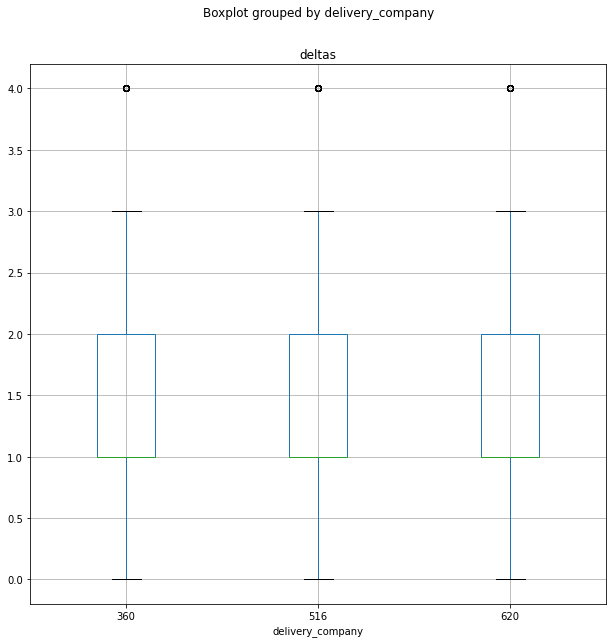

In [24]:
deliveries_clean.boxplot(column="deltas",by='delivery_company',figsize=(10,10))

In [25]:
deliveries.describe()

,purchase_id,deltas
count,7493.000000,7493.000000
mean,23747.000000,1.335246
std,2163.187116,0.872846
min,20001.000000,0.000000
25%,21874.000000,1.000000
50%,23747.000000,1.000000
75%,25620.000000,2.000000
max,27493.000000,4.000000


Text(0, 0.5, 'User count')

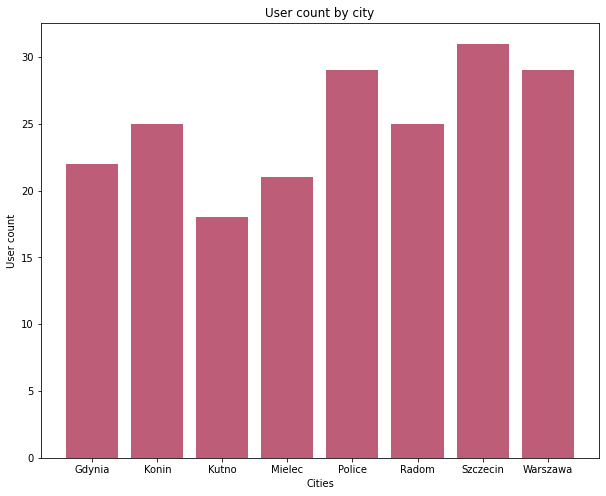

In [26]:
# Client location analysis - knowing where clients live is crucial to estimate delivery time
# The smaller the city is, the delivery time gets longer
cityCount = d.users.groupby('city', as_index=False).user_id.count()
plt.figure(figsize=(10, 8))
plt.bar(cityCount.city, cityCount.user_id, color='#BE5D77')
plt.title("User count by city")
plt.xlabel("Cities")
plt.ylabel("User count")

In [27]:
# Joining dataframes to further use in other plots
# We want to check whether there is a relationship between cities and delivery time.
deliveries_ses_user = deliveries_clean.merge(d.sessions[['user_id', 'purchase_id', 'product_id']], on='purchase_id')
deliveries_ses_user = deliveries_ses_user.merge(d.users[['user_id','city']], on='user_id')

<AxesSubplot:title={'center':'deltas'}, xlabel='city'>

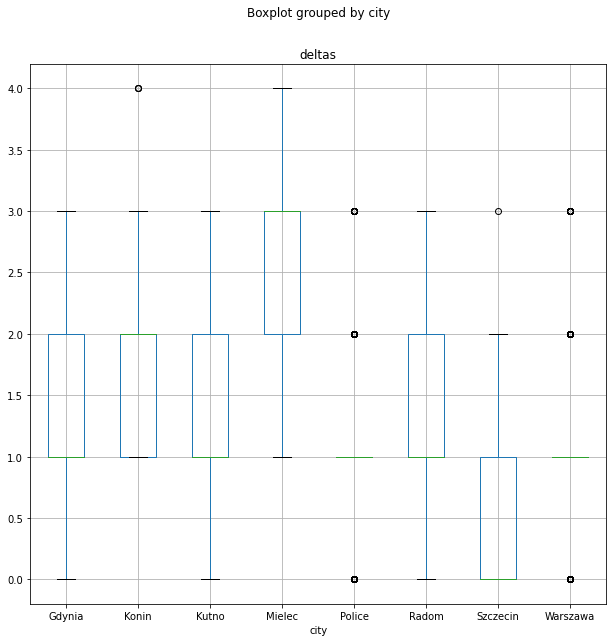

In [28]:
deliveries_ses_user.boxplot(column="deltas",by='city',figsize=(10,10))

Text(0, 0.5, 'Deliveries mean')

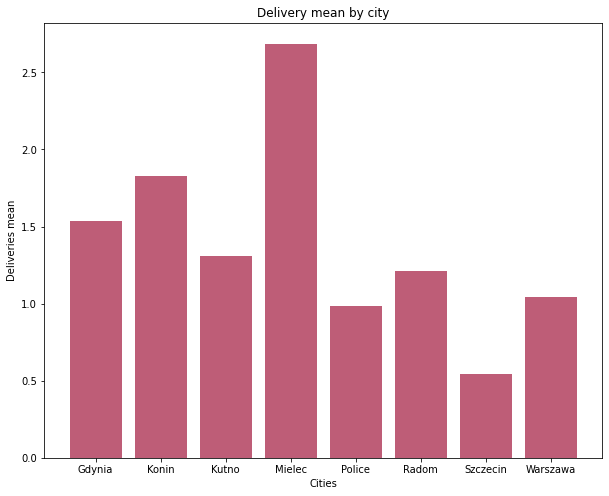

In [29]:
# Turned out boxplots weren't helpful so we check the mean for each city
deliveries_city = deliveries_ses_user.groupby('city', as_index=False).deltas.mean()
plt.figure(figsize=(10, 8))
plt.bar(deliveries_city.city, deliveries_city.deltas, color='#BE5D77')
plt.title("Delivery mean by city")
plt.xlabel("Cities")
plt.ylabel("Deliveries mean")

In [30]:
#Joining products dataframe to check the relationship between delivery time and product category.
deliveries_ses_user_prod = deliveries_ses_user.merge(products, on='product_id')


<AxesSubplot:title={'center':'deltas'}, xlabel='primary_category'>

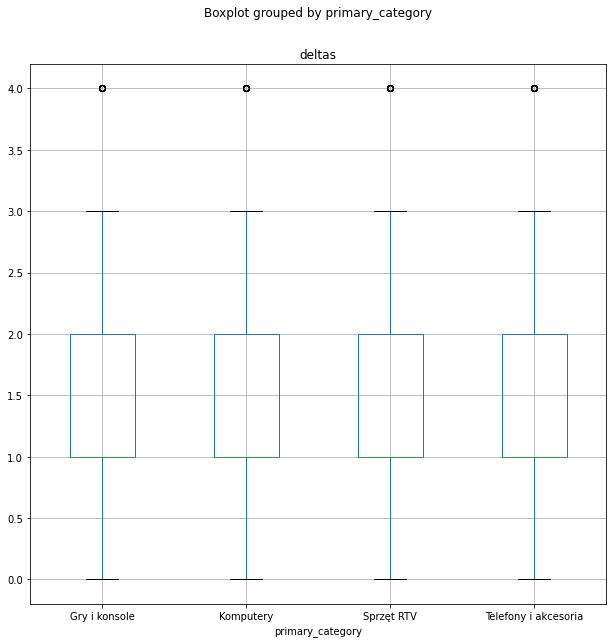

In [31]:
deliveries_ses_user_prod.boxplot(column="deltas",by='primary_category',figsize=(10,10))

Text(0, 0.5, 'Deliveries mean')

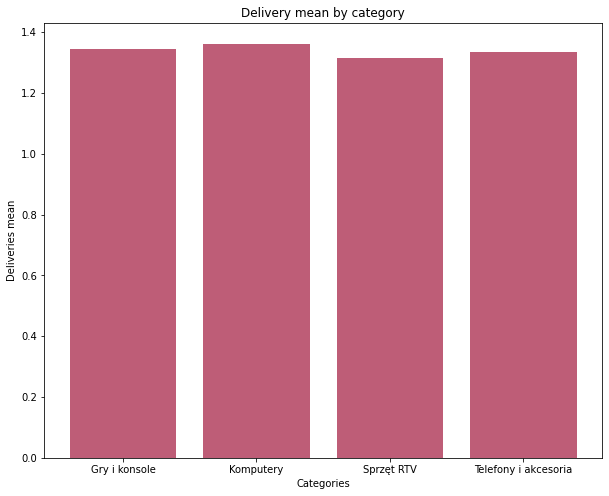

In [32]:
#Checking the mean for categories as well
deliveries_category = deliveries_ses_user_prod.groupby('primary_category', as_index=False).deltas.mean()
plt.figure(figsize=(10, 8))
plt.bar(deliveries_category.primary_category, deliveries_category.deltas, color='#BE5D77')
plt.title("Delivery mean by category")
plt.xlabel("Categories")
plt.ylabel("Deliveries mean")

<AxesSubplot:title={'center':'deltas'}, xlabel='weekday'>

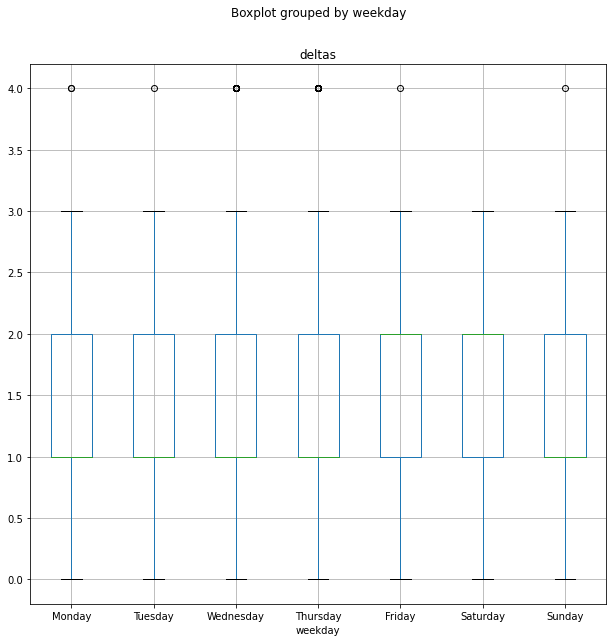

In [33]:
#Adding new column with day of the week and checking its relationship with delivery time
deliveries_ses_user_prod['weekday'] = deliveries_ses_user_prod['purchase_timestamp'].dt.day_name()
deliveries_ses_user_prod.boxplot(column="deltas",by='weekday',figsize=(10,10), positions=[4,0,5,6,3,1,2])


Text(0, 0.5, 'Deliveries mean')

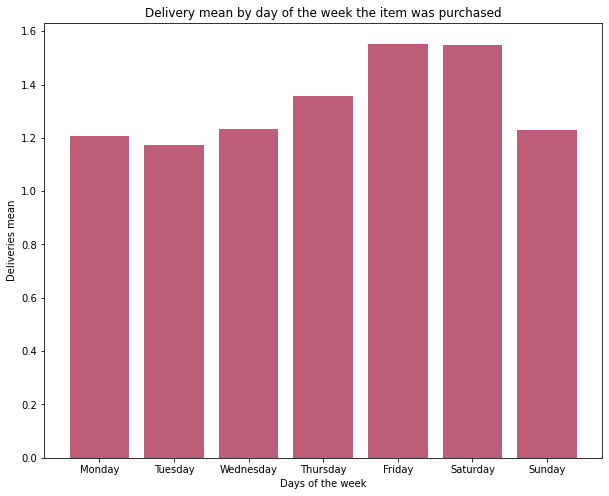

In [34]:
# No simple way to reorder the bars in matplotlib, so we had to use this trick
# We create an artificial key, by which we will sort dataframe
work_df = deliveries_ses_user_prod
work_df = work_df.groupby('weekday').deltas.mean().reset_index()
work_df = work_df.reindex([1,5,6,4,0,2,3])
plt.figure(figsize=(10, 8))

plt.bar(work_df.weekday, work_df.deltas, color='#BE5D77')
plt.title("Delivery mean by day of the week the item was purchased")
plt.xlabel("Days of the week")
plt.ylabel("Deliveries mean")

In [35]:
#Function for labeling rows
def labelTimeOfDay(row):
    hour = row['purchase_timestamp'].hour
    if(hour >= 6 and hour < 12):
        return "Morning"
    elif(hour >= 12 and hour < 18):
        return "Afternoon"
    elif(hour >=18 and hour < 24):
        return "Evening"
    else:
        return "Night"

In [36]:
#Using the function above to label all the rows
deliveries_clean.loc[:,'time_of_day'] = deliveries_clean.apply(lambda row: labelTimeOfDay(row), axis=1)

<AxesSubplot:title={'center':'deltas'}, xlabel='time_of_day'>

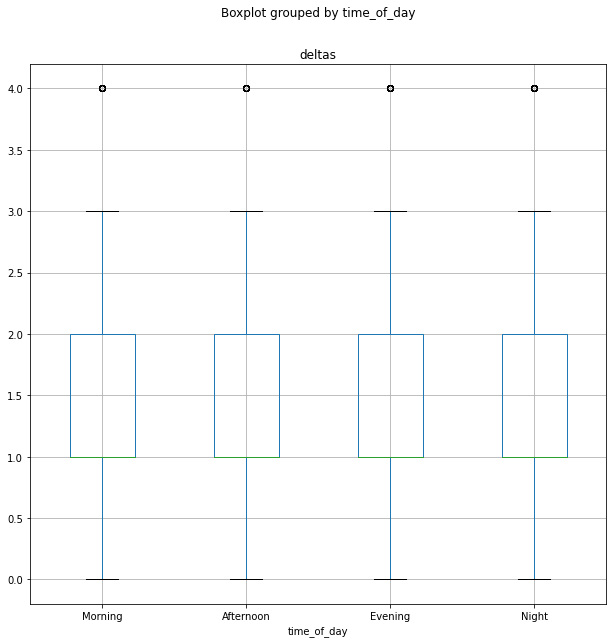

In [37]:
#Checking the relationship between the time of the day when we purchased the item and its delivery time
deliveries_clean.boxplot(column="deltas",by='time_of_day',figsize=(10,10), positions=[1,2,0,3])

Text(0, 0.5, 'Deliveries mean')

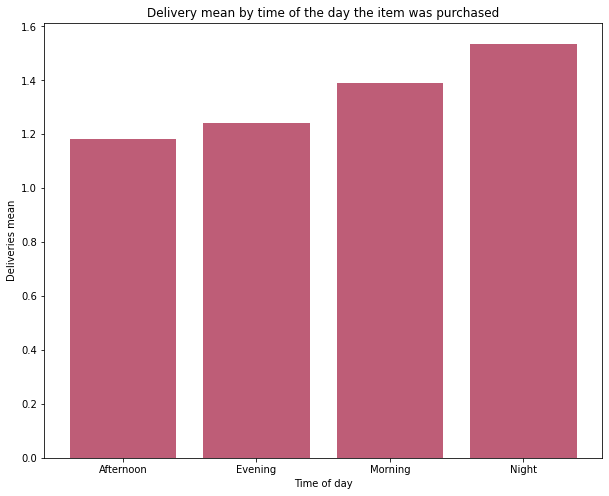

In [38]:
# Once again checking the mean for other clues
deliveries_clean = deliveries_clean.groupby('time_of_day', as_index=False).deltas.mean()
plt.figure(figsize=(10, 8))
plt.bar(deliveries_clean.time_of_day, deliveries_clean.deltas, color='#BE5D77')
plt.title("Delivery mean by time of the day the item was purchased")
plt.xlabel("Time of day")
plt.ylabel("Deliveries mean")

In [39]:
# Investigating negative values of delta column 
deliveries_ses_user_prod_neg = deliveries_ses_user_prod[deliveries_ses_user_prod['deltas'] < 0]

In [40]:
deliveries_ses_user_prod

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,deltas,user_id,product_id,city,product_name,price,primary_category,secondary_category,tertiary_category,quaternary_category,weekday
0,20001,2021-04-01 15:52:47,2021-04-02 14:06:34.432964,620,0.0,102,1234,Police,Sony DVP-SR760,193.00,Sprzęt RTV,Video,Odtwarzacze DVD,None,Thursday
1,20007,2021-03-20 18:27:55,2021-03-22 08:29:45.390812,360,1.0,102,1234,Police,Sony DVP-SR760,193.00,Sprzęt RTV,Video,Odtwarzacze DVD,None,Saturday
2,20107,2021-03-16 10:22:53,2021-03-19 08:14:38.517266,620,2.0,104,1234,Mielec,Sony DVP-SR760,193.00,Sprzęt RTV,Video,Odtwarzacze DVD,None,Tuesday
3,20152,2021-02-11 09:12:13,2021-02-12 08:04:51.353372,620,0.0,106,1234,Szczecin,Sony DVP-SR760,193.00,Sprzęt RTV,Video,Odtwarzacze DVD,None,Thursday
4,20166,2021-02-27 07:03:22,2021-02-27 17:47:32.804338,360,0.0,106,1234,Szczecin,Sony DVP-SR760,193.00,Sprzęt RTV,Video,Odtwarzacze DVD,None,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7488,27145,2021-01-21 20:46:37,2021-01-25 08:32:11.284177,620,3.0,293,1011,Mielec,BioShock Infinite (Xbox 360),139.99,Gry i konsole,Gry na konsole,Gry Xbox 360,None,Thursday
7489,27227,2021-01-08 19:25:07,2021-01-09 16:22:51.365641,516,0.0,296,1011,Warszawa,BioShock Infinite (Xbox 360),139.99,Gry i konsole,Gry na konsole,Gry Xbox 360,None,Friday
7490,27262,2021-03-04 12:24:22,2021-03-05 08:39:33.046799,516,0.0,297,1011,Szczecin,BioShock Infinite (Xbox 360),139.99,Gry i konsole,Gry na konsole,Gry Xbox 360,None,Thursday
7491,27303,2021-04-23 21:18:55,2021-04-26 08:59:02.125839,620,2.0,299,1011,Konin,BioShock Infinite (Xbox 360),139.99,Gry i konsole,Gry na konsole,Gry Xbox 360,None,Friday


In [41]:
# Rows with negative values represent around 31% of the whole dataset 
percent = len(deliveries_ses_user_prod_neg.index)/len(deliveries_ses_user_prod.index)
print(round(percent,2))

0.0


In [42]:
# Analyzing the problem of NaT values in timestamps columns in deliveries dataframe
deliveries = d.deliveries
deliveries_empty = deliveries[deliveries.purchase_timestamp.isnull() | deliveries.delivery_timestamp.isnull()]
percent = len(deliveries_empty)/len(deliveries)
print(round(percent,2))

0.0


In [43]:
# There is no problem with checking when the item was purchased on the site
print(len(deliveries[deliveries.purchase_timestamp.isnull()]))

0


In [44]:
delivery_empty = deliveries[deliveries.delivery_timestamp.isnull()]
delivery_grouped = deliveries_empty.groupby('delivery_company', as_index=False).purchase_id.count()

Text(0, 0.5, 'Number of empty rows')

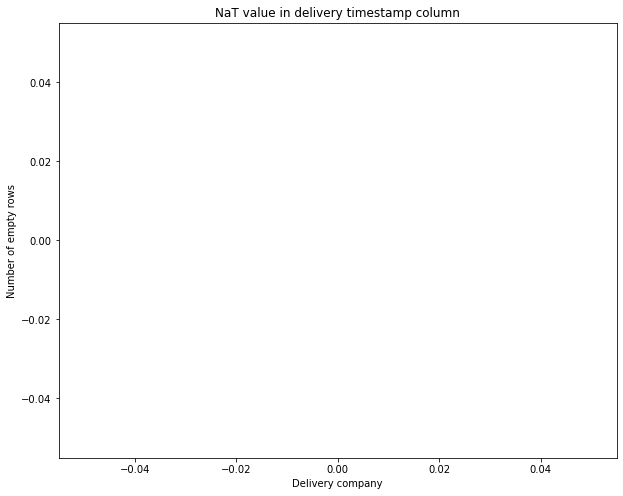

In [45]:
plt.figure(figsize=(10, 8))
plt.bar(delivery_grouped.delivery_company.astype(str), delivery_grouped.purchase_id, color='#BE5D77')
plt.title("NaT value in delivery timestamp column")
plt.xlabel("Delivery company")
plt.ylabel("Number of empty rows")

In [46]:
delivery_empty

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,deltas


In [47]:
# Trying to understand why there are so many empty rows
deliveries = d.deliveries
deliveries_empty = deliveries[deliveries.isna().any(axis=1)]

In [48]:
# Searching for last delivery by each company
deliveries_grouped = deliveries.groupby('delivery_company')['delivery_timestamp']
deliveries_empty = deliveries_empty.assign(max=deliveries_grouped.transform(max))
deliveries_empty.loc[:,'max_delta'] = deliveries_empty['max'] - deliveries_empty['purchase_timestamp']
deliveries_empty.dtypes
deliveries_empty["max_delta"] = deliveries_empty["max_delta"].astype('timedelta64[D]')
deliveries_empty.boxplot(column="max_delta",by='delivery_company',figsize=(10,10))

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
#sklearn is used only to split in a good way data
from sklearn.model_selection import train_test_split
train, test = train_test_split(deliveries_ses_user_prod, test_size=0.2)

In [ ]:
train